In [319]:
import asyncio
import websockets
import json
import pandas as pd
import datetime as dt
import nest_asyncio
from concurrent.futures import ThreadPoolExecutor
nest_asyncio.apply()

import csv
from scipy import stats
import os

import datetime
from pandas.io.json import json_normalize
import numpy as np
from scipy import interpolate
import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import skewnorm
import matplotlib.pyplot as plt

from market_data import HistData
from market_data import Options

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [359]:
posn_path = os.path.join(os.getcwd(), "performance_analytics","positions.xlsx")
idx_path = os.path.join(os.getcwd(), "performance_analytics","eth_index.csv")
val_path = "c:\\Users\\kmavy\\Documents\\mydocs\\Training Arc\\Github\\QuantMasterFund\\Crypto\\val.xlsx"

In [360]:
hdata = HistData('ETH')
start_dt = int(pd.to_datetime('20240101').timestamp()*1000)
end_dt = int(pd.datetime.today().timestamp()*1000)
eth_idx = hdata.get_hist_data(start_dt,end_dt,'ETH-PERPETUAL','1D')[['close']]
eth_idx.index = [dt.strftime('%Y-%m-%d') for dt in eth_idx.index]
eth_idx.index.names = ['Date']
#eth_idx.to_csv(idx_path)

In [361]:
eth_idx.to_csv(idx_path)

In [362]:
eth_idx

,close
Date,
2023-12-31,2285.40
2024-01-01,2391.15
2024-01-02,2363.35
2024-01-03,2224.55
2024-01-04,2255.15
...,...
2024-03-27,3572.75
2024-03-28,3519.35
2024-03-29,3492.80


In [676]:
positions = pd.read_excel(posn_path,index_col = 0)
idx_px = pd.read_csv(idx_path,index_col = 0)
val = pd.read_excel(val_path,index_col = 0)

In [677]:
idx_px.index= pd.to_datetime(idx_px.index)
val.index = pd.to_datetime(val.index)

In [678]:
indices = pd.date_range(start_dt,pd.datetime.today())
#indices = [dt.strftime("%Y-%m-%d") for dt in indices]
skeleton = pd.DataFrame(index =indices ,columns = ['positions'])
positions = positions.reindex_like(skeleton).fillna(method = 'ffill')
positions2 = positions.copy()
positions2.index = [dt.strftime("%Y-%m-%d") for dt in indices]
positions2.to_excel(posn_path)

In [679]:
latest_val = val.iloc[-1][0]
#dep = int(input())
dep = latest_val
latest_val = pd.DataFrame([dep],index = [pd.datetime.today().date()],columns = ['val'])

In [680]:
start_dt = val.index[0]
skeleton = pd.DataFrame(index = pd.date_range(start_dt,pd.datetime.today()),columns = ['val'])
val = val.reindex_like(skeleton).fillna(method = 'ffill')
val.to_excel(val_path)

In [681]:
positions

,positions
2024-01-01,0.80000
2024-01-02,0.80000
2024-01-03,0.80000
2024-01-04,0.80000
2024-01-05,0.80000
...,...
2024-03-28,0.83152
2024-03-29,0.83152
2024-03-30,0.83152
2024-03-31,0.83152


with open(val_path,'a',newline = '') as csvfile:
    writer = csv.writer(csvfile)
    for i in range(len(latest_val)):
        temp = latest_val.reset_index()
        row = temp.iloc[i].values
        writer.writerow(row)
csvfile.close()


In [682]:
val = pd.read_excel(val_path,index_col = 0)
val

,val
2024-01-01,3000
2024-01-02,3000
2024-01-03,3000
2024-01-04,3000
2024-01-05,3000
...,...
2024-03-28,3000
2024-03-29,3000
2024-03-30,3000
2024-03-31,3000


In [683]:
#idx_px.index = [dt.strftime('%Y/%d/%') for dt in pd.to_datetime(idx_px.index)]
#positions.index = [dt.strftime('%Y-%d-%d') for dt in pd.to_datetime(positions.index)]

idx_px.index.names,positions.index.names = ['Date'],['Date']

In [684]:
usd_rets = positions.join(idx_px,on='Date',how = 'left')
usd_rets['Tactical Beta Convexity'] = usd_rets['close'].diff()*usd_rets['positions']

In [685]:
usd_rets = usd_rets.dropna()
usd_rets.dropna()

,positions,close,Tactical Beta Convexity
Date,,,
2024-01-02,0.80000,2363.35,-22.240000
2024-01-03,0.80000,2224.55,-111.040000
2024-01-04,0.80000,2255.15,24.480000
2024-01-05,0.80000,2233.35,-17.440000
2024-01-06,0.80000,2250.25,13.520000
...,...,...,...
2024-03-27,0.83152,3572.75,2.827168
2024-03-28,0.83152,3519.35,-44.403168
2024-03-29,0.83152,3492.80,-22.076856


In [686]:
vol_float_pnl_path = "c:\\Users\\kmavy\\Documents\\mydocs\\Training Arc\\Github\\QuantMasterFund\\Crypto\\Volatility\\ShortVolatility\\performance_analytics\\floating_rets.csv"
vol_rel_pnl_path = "c:\\Users\\kmavy\\Documents\\mydocs\\Training Arc\\Github\\QuantMasterFund\\Crypto\\Volatility\\ShortVolatility\\performance_analytics\\realized_rets.csv"

In [687]:
vol_float_rets = pd.read_csv(vol_float_pnl_path,index_col = 0)
vol_rel_rets = pd.read_csv(vol_rel_pnl_path,index_col = 0)
vol_rel_rets = vol_rel_rets.groupby(vol_rel_rets.index).sum()
vol_rel_rets = vol_rel_rets[['PnL','txn_cost']]
#vol_rel_rets = vol_rel_rets['PnL']-vol_rel_rets['txn_cost']
vol_rel_rets

,PnL,txn_cost
Date,,
2024-02-26,-0.00018,0.003000
2024-02-27,-0.03128,0.004200
2024-03-05,0.11197,0.006000
2024-03-08,-0.05790,0.010263
2024-03-09,-0.01400,0.006000
2024-03-10,0.00450,0.001800
2024-03-17,-0.01790,0.013600
2024-03-22,0.02760,0.004800
2024-03-29,0.01750,0.001500


In [688]:

#vol_float_rets.index = [dt.strftime('%Y-%m-%d') for dt in pd.to_datetime(vol_float_rets.index,format = "%d/%m/%Y")]
#vol_rel_rets.index = [dt.strftime('%Y-%m-%d') for dt in pd.to_datetime(vol_rel_rets.index,format = "%Y-%m-%d")]

In [689]:
vol_rets = pd.DataFrame(pd.concat([vol_float_rets,vol_rel_rets[['PnL']]],axis=1).sum(axis=1),columns = ['Short Volatility'])
vol_rets = pd.concat([vol_rets,vol_rel_rets[['txn_cost']]],axis=1)
vol_rets.columns  = ['Short Volatility','Txn Cost']
vol_rets.fillna(0,inplace = True)

In [690]:
curr_px = usd_rets['close'].iloc[-1]
vol_rets = vol_rets*curr_px

In [691]:
convexity = usd_rets[['Tactical Beta Convexity']]
convexity.index = [dt.strftime('%Y-%m-%d') for dt in pd.to_datetime(convexity.index)]

In [692]:
convexity

,Tactical Beta Convexity
2024-01-02,-22.240000
2024-01-03,-111.040000
2024-01-04,24.480000
2024-01-05,-17.440000
2024-01-06,13.520000
...,...
2024-03-27,2.827168
2024-03-28,-44.403168
2024-03-29,-22.076856
2024-03-30,108.679664


In [693]:
vol_rets.index = [dt.strftime('%Y-%m-%d') for dt in pd.to_datetime(vol_rets.index)]

In [694]:
usd_rets = pd.concat([convexity,vol_rets],axis=1).fillna(0)
usd_rets

,Tactical Beta Convexity,Short Volatility,Txn Cost
2024-01-02,-22.240000,0.000000,0.0000
2024-01-03,-111.040000,0.000000,0.0000
2024-01-04,24.480000,0.000000,0.0000
2024-01-05,-17.440000,0.000000,0.0000
2024-01-06,13.520000,0.000000,0.0000
...,...,...,...
2024-03-28,-44.403168,5.797441,0.0000
2024-03-29,-22.076856,77.437027,5.4363
2024-03-30,108.679664,-49.529705,0.0000
2024-03-31,0.582064,7.248400,0.0000


In [695]:

usd_rets['Total (Cost Adjusted)'] = usd_rets['Tactical Beta Convexity']+usd_rets['Short Volatility']-usd_rets['Txn Cost']
usd_rets.index.names = ["Date"]

<Axes: xlabel='Date'>

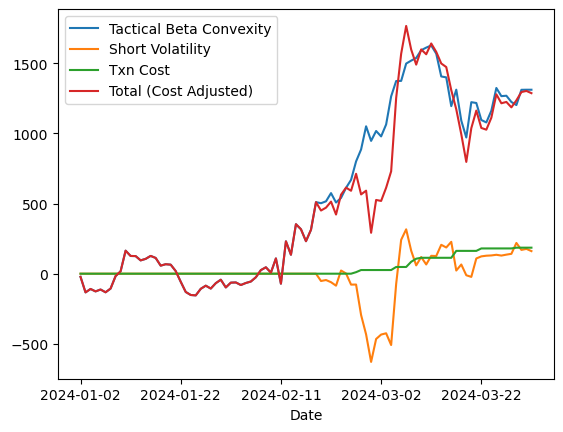

In [696]:
usd_rets.cumsum().plot()

In [697]:
val.index = [dt.strftime("%Y-%m-%d") for dt in pd.to_datetime(val.index)]
vals = pd.concat([usd_rets,val],axis=1)['val']

In [698]:
usd_rets = pd.concat([usd_rets.cumsum(),val],axis=1).dropna()

In [699]:
for col in usd_rets.columns:
    usd_rets[col]=usd_rets[col]+usd_rets['val']



In [700]:
usd_rets.index = pd.to_datetime(usd_rets.index)

In [701]:
usd_rets = usd_rets[['Total (Cost Adjusted)','Short Volatility','Tactical Beta Convexity','Txn Cost']]

In [702]:
eth_idx.index = pd.to_datetime(eth_idx.index)

In [703]:
usd_rets = pd.concat([usd_rets,eth_idx],axis=1).fillna(method = 'ffill')

In [704]:
usd_rets

,Total (Cost Adjusted),Short Volatility,Tactical Beta Convexity,Txn Cost,close
2023-12-31,NaN,NaN,NaN,NaN,2285.40
2024-01-01,NaN,NaN,NaN,NaN,2391.15
2024-01-02,2977.760000,3000.000000,2977.760000,3000.000000,2363.35
2024-01-03,2866.720000,3000.000000,2866.720000,3000.000000,2224.55
2024-01-04,2891.200000,3000.000000,2891.200000,3000.000000,2255.15
...,...,...,...,...,...
2024-03-28,4185.427579,3141.618195,4223.796216,3179.986832,3519.35
2024-03-29,4235.351450,3219.055223,4201.719360,3185.423132,3492.80
2024-03-30,4294.501409,3169.525518,4310.399024,3185.423132,3623.50
2024-03-31,4302.331873,3176.773918,4310.981088,3185.423132,3624.20


In [705]:
usd_rets.columns = ['Total (Cost Adjusted)','Short Volatility','Tactical Beta Convexity','Cost','Index']

In [706]:
usd_rets = usd_rets[['Total (Cost Adjusted)','Short Volatility','Tactical Beta Convexity','Index']]

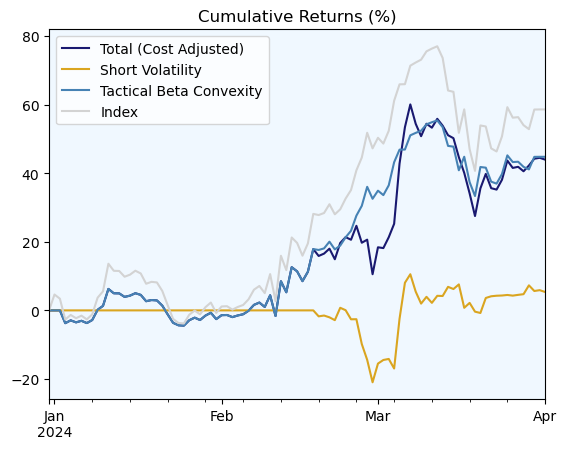

In [707]:
plot = (((1+(usd_rets.pct_change()).fillna(0)).cumprod()-1)*100).plot(title = 'Cumulative Returns (%)',color = ['midnightblue','goldenrod','steelblue','lightgrey'])
#(((1+eth_idx.pct_change()).cumprod()-1)*100).plot()
plot.set_facecolor('aliceblue')
picpath = "c:\\Users\\kmavy\\Documents\\mydocs\\Training Arc\\Github\\QuantMasterFund\\Crypto\\MasterFundPerformance.png"
plot.get_figure().savefig(picpath)

In [708]:
rets = usd_rets[['Total (Cost Adjusted)']].pct_change().fillna(0)

In [709]:
np.sqrt(252)* rets.mean()/rets.std()

Total (Cost Adjusted)    2.158045
dtype: float64

<Axes: title={'center': 'Master Fund Expanding-Window Sharpe Ratio'}>

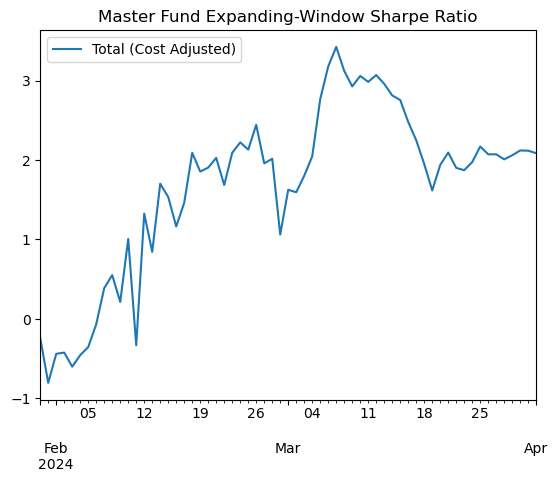

In [710]:
(np.sqrt(252)* (rets.expanding().mean()-0.053/350)/rets.expanding().std())[30:].plot(title = 'Master Fund Expanding-Window Sharpe Ratio')